#  Modélisation simple de la diffusion d'une information 

## 1. Mise en place des matrices de liaisons et transmission d'une information

Commençons par définir des matrices de liaisons. Chaque personne d'un réseau d'amis, à qui nous attribuons une ligne dans la matrice, est connectée à un nombre d'amis plus ou moins aléatoire. Pour une population de n personnes, il y aura donc n colonnes dans la matrices. La connection entre deux agents se traduira par un 1 au lieu d'un 0 dans la matrice de liaisons. 

En définissant ensuite une matrice ligne "info" comprenant un 1 à l'indice correspondant à la personne ayant l'information au début du processus, on peut appliquer la multiplication de cette matrice par la matrice de liaisons. On obtient ainsi une nouvelle matrice "info" présentant quels agents ont l'information après la diffusion de l'agent émetteur.

Pour complexifier ce modèle simple et se rapprocher de la réalité, il est nécessaire de prendre en compte d'autres facteurs : probabilités d'envoyer l'information pour une personne ayant eu l'info au temps d'avant, probabilité de voir l'info ...

Voici une fonction permettant d'obtenir 2 matrices : 
* la liste des personnes ayant reçu ET vu l'info
* la liste des personnes ayant partagé l'info et ne pouvant donc plus la partager (ici uniquement l'emetteur initial)

In [2]:
import matplotlib 

In [3]:
import random
Liaisons=[[0,1,0,1,0],[1,0,0,1,1],[1,0,0,1,1],[1,1,0,0,1],[0,1,1,0,0]]
info=[1,0,0,0,0]  #personnes qui vont transmettre l'information
stock_info=[1,0,0,0,0]  #nombres de fois que chaque personne à recu l'info
nbr=1 #nbr de personnes totales à avoir eu l'information
probas={"Recevoir":0.8,"Envoyer":0.5}


def passage_info_simple(liaisons,info,stock_info,nbr):
    """list[list[int]]*list[int]*list[int]*int->list[int]
    Transmet l'information à la géneration suivante"""
    new_info=[0 for i in info]
    new_stock_info=[i for i in stock_info]
    for i in range(len(info)):
        if info[i]==1:
            for a in range(len(liaisons[i])):
                rdm=random.random()
                if liaisons[i][a]==1 and rdm<probas["Envoyer"]: #a modifier pour modèle complexe
                    if new_stock_info[a]<1 and rdm<probas["Recevoir"]: #a modifier pour modèle complexe
                        new_info[a]=1
                        nbr+=1
                        new_stock_info[a]+=1
                    elif rdm<probas["Recevoir"]:
                        new_stock_info[a]+=1
                
    return new_info,new_stock_info,nbr

print(passage_info_simple(Liaisons,info,stock_info,nbr))




([0, 0, 0, 0, 0], [1, 0, 0, 0, 0], 1)


En faisant tourner cette fonction un très grand nombre n de fois, on devrait se rapprocher très fortement de la probabilité d'envoyé l'info définie (0.5 ici). La fonction suivante éxecute ceci.

In [4]:
def test_probas(n):
    compte=0
    for i in range(n):
        if passage_info_simple(Liaisons,info,stock_info,nbr)[2] == 2:
            compte +=1
    return compte/n
print(test_probas(100000))
     

0.50114


Nous transferons maintenant l'information plusieurs fois. Pour cela, nous executons simplement n fois la fonction passage_info_simple pour obtenir la matrice info. Si tous les agents ont reçu l'info la fonction s'arrête, sinon, elle renvoie la matrice info à la fin de la diffusion.

In [6]:
def transfert_n_generations(liaisons,info,stock_info,nbr,n):
    """list[list[int]]*list[int]*list[int]*int*int->list[int]
    transmet l'informations n fois, retourne info,stock_info et nbr chaque étape"""
    Ltemp=[i for i in info]
    stocktemp=[i for i in stock_info]
    nbrtemp=nbr
    for i in range(n):
        temp=passage_info_simple(liaisons,Ltemp,stocktemp,nbrtemp)
        Ltemp=[i for i in temp[0]]
        stocktemp=[i for i in temp[1]]
        nbrtemp=temp[2]
        print(Ltemp,stocktemp,nbrtemp)
        if nbrtemp==len(liaisons): 
            return "Information diffusée !"
        
    return Ltemp
print(transfert_n_generations(Liaisons,info,stock_info,nbr,5))   

[0, 1, 0, 0, 0] [1, 1, 0, 0, 0] 2
[0, 0, 0, 0, 1] [2, 1, 0, 0, 1] 3
[0, 0, 1, 0, 0] [2, 1, 1, 0, 1] 4
[0, 0, 0, 1, 0] [3, 1, 1, 1, 2] 5
Information diffusée !


## 2. Mise en place de l'interface graphique avec NetworkX

Cette bibliothèque s'applique totalement à notre sujet. En effet, elle permet de tracer des "réseaux neuronaux" : chaque agent sera relié à ses amis. 

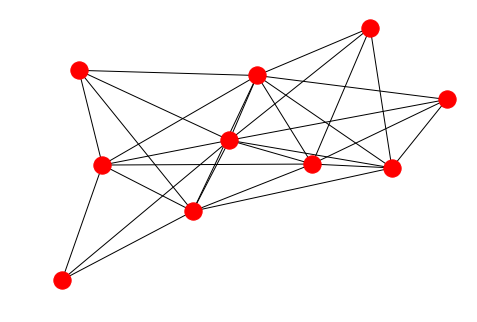

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.random_geometric_graph(10,0.56)
#plt.subplot(121)
nx.draw(G)
nodes=G.nodes(data=True)


En utilisant nos matrices de liaisons créées plus haut, on peut facilement tracer notre réseau afin de visualiser les liens entre chaque agents.

In [11]:
Liaisons=[[0,1,0,0,0],[1,0,0,1,1],[1,1,0,1,1],[1,1,0,0,1],[0,1,1,0,0]]

def draw_liaisons(l):
    """list[list[int]]->NoneType
    renvoi le dessin des liaisons à partir de la matrice liaisons"""
    G=nx.Graph()
    i=len(l)
    G.add_nodes_from([elt for elt in range(i)])
    for elt in range(len(l)):
        for elt2 in range(len(l[elt])):
            if l[elt][elt2]==1:
                G.add_edge(elt,elt2)
    return nx.draw(G,with_labels=True)
    

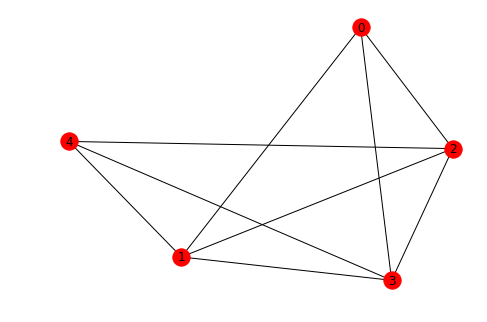

In [5]:
draw_liaisons(Liaisons)

 ## 3. Génération d'un réseau aléatoire et diffusion d'une information

Pour les n agents de la population, le nombre d'amis et le choix des liaisons avec les autres agents sont définis aléatoirement grâce aux deux fonctions ci-dessous.

In [17]:
import math
def nbr_amis(personne):
    """list[int]->int
    renvoie le nombre d'amis d'une personne à partir d'une liste de 0 et de 1"""
    nbr=0
    for elt in range(len(personne)):
        if elt==1:
            nbr+=1
    return nbr

def choisir_amis(no_personne,n,nbr_moy):
    """int*int->list[int]
    renvoie les une liste avec les amis choisis d'une personne"""
    LR=[]
    exclusion= [i for i in range(n) if i!=no_personne]
    last=0
    for elt in range(nbr_moy):
        last=random.choice(exclusion)
        LR.append(last)
        exclusion.remove(last)
    return LR
        
        

            
def donneur_info(population,donneur):
    """int*int->list[int]+list[int]
    donne les matrices info et stock_info"""
    info=[0 if i!= donneur else 1 for i in range(population)]
    return info



info=[i for i in donneur_info(180,7)]


La fonction graph_simple_generator permet de générer un réseau aléatoire et de le tracer avec NetworkX.

In [25]:
def simple_graph_generator(n):
    """int->list[list[int]]
    Genere un réseaux d'amis aléatoire avec n le nombre de personnes"""
    LR=[[0 for elt in range(n)] for i in range(n)]
    nbr_moy=int(n*2/13) #Trouver la bonne fonction
    for elt in range(n):
        amis=choisir_amis(elt,n,nbr_moy)
        for elt2 in amis:
            tolerance=round(n*1/5)
            if nbr_amis(LR[elt]) <= nbr_moy+tolerance and nbr_amis(LR[elt2]) <= nbr_moy+tolerance:
                LR[elt][elt2]=1
                LR[elt2][elt]=1
    return LR

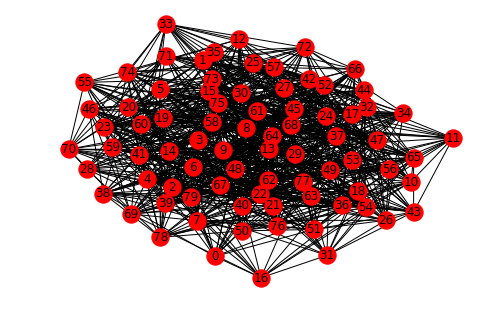

In [24]:
draw_liaisons(simple_graph_generator(80))


[[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,

On diffuse ensuite l'information dans ce groupe généré en réutilisant la fonction précédante, transferant l'information n fois.

In [19]:
graph=simple_graph_generator(180)
print(transfert_n_generations(graph,info,info,1,10))

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,

On peut maintenant tracer l'évolution du nombre de personnes ayant eu l'information au courd du temps.

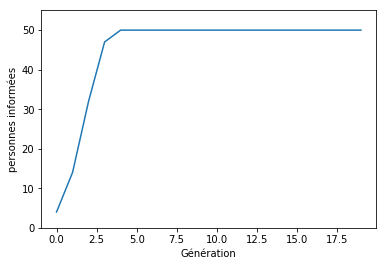

In [27]:
probas={"Recevoir":0.7,"Envoyer":0.3}
def nbr_evolution(liaisons,info,stock_info,nbr,n):
    """list[list[int]]*list[int]*list[int]*int*int->int
   renvoie la liste du nombre de personnes ayant l'information à chaque géneration"""
    Ltemp=[i for i in info]
    stocktemp=[i for i in stock_info]
    nbrtemp=nbr
    NBR=[]
    for i in range(n):
        temp=passage_info_simple(liaisons,Ltemp,stocktemp,nbrtemp)
        Ltemp=[i for i in temp[0]]
        stocktemp=[i for i in temp[1]]
        nbrtemp=temp[2]
        NBR.append(nbrtemp)
    return NBR

def plot_information(L,taille):
    '''
    list[int]-> None
    Visualise l'évolution du opartage de l'information au cours du temps
    '''
    plt.figure()
    plt.plot(L)
    plt.ylim(0,taille+5)
    plt.ylabel("personnes informées")
    plt.xlabel("Génération")
    plt.show()
    return
generate=simple_graph_generator(50)
donneur=donneur_info(50,27)
stock=[i for i in donneur]
listevo=nbr_evolution(generate,donneur,stock,1,20)
plot_information(listevo,50)